In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install /content/drive/MyDrive/HAI/eTaPR-21.8.2-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/HAI/eTaPR-21.8.2-py3-none-any.whl


In [3]:
import numpy as np
import torch

In [4]:
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [6]:
train_data1 = pd.read_csv("/content/drive/MyDrive/HAI/train1.csv", sep=";", engine="python")
train_data2 = pd.read_csv("/content/drive/MyDrive/HAI/train2.csv", sep=";", engine="python")

In [7]:
TRAIN_DF_RAW = pd.concat([train_data1, train_data2], axis=0).reset_index(drop=True)

In [8]:
TIMESTAMP_FIELD = "time"
ATTACK_FIELD = "attack"
USELESS_FIELDS = ["attack_P1", "attack_P2", "attack_P3"]
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(
    [TIMESTAMP_FIELD, ATTACK_FIELD] + USELESS_FIELDS
)
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_B4005',
       'P1_B400B', 'P1_B4022', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D',
       'P1_FCV02Z', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02',
       'P1_FT02Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01',
       'P1_PCV01D', 'P1_PCV01Z', 'P1_PCV02D', 'P1_PCV02Z', 'P1_PIT01',
       'P1_PIT02', 'P1_TIT01', 'P1_TIT02', 'P2_24Vdc', 'P2_Auto', 'P2_Emgy',
       'P2_On', 'P2_SD01', 'P2_SIT01', 'P2_TripEx', 'P2_VT01e', 'P2_VXT02',
       'P2_VXT03', 'P2_VYT02', 'P2_VYT03', 'P3_LCP01D', 'P3_LCV01D', 'P3_LH',
       'P3_LL', 'P3_LT01', 'P4_HT_FD', 'P4_HT_LD', 'P4_HT_PO', 'P4_HT_PS',
       'P4_LD', 'P4_ST_FD', 'P4_ST_LD', 'P4_ST_PO', 'P4_ST_PS', 'P4_ST_PT01',
       'P4_ST_TT01'],
      dtype='object')

In [9]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [10]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [11]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z,...,P4_HT_LD,P4_HT_PO,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
0,0.950413,0.482115,0.092349,0.924352,0.875635,0.0,0.003453,0.747782,0.0,0.000303,...,0.774283,0.695151,0.0,0.611301,0.482464,0.512735,0.510764,0.990676,0.28169,0.999920
1,0.950413,0.481979,0.092349,0.924352,0.875635,0.0,0.003767,0.747643,0.0,0.000303,...,0.777126,0.701872,0.0,0.622405,0.475571,0.510729,0.512880,0.990676,0.28169,0.999920
2,0.950413,0.482146,0.092349,0.924352,0.875635,0.0,0.002862,0.747848,0.0,0.000371,...,0.779809,0.710901,0.0,0.621954,0.500568,0.518915,0.514905,0.990676,0.28169,0.999920
3,0.950413,0.482878,0.092349,0.924352,0.875635,0.0,0.004637,0.748913,0.0,0.000242,...,0.782420,0.717861,0.0,0.624446,0.515840,0.517326,0.521391,0.990676,0.28169,0.999920
4,0.950413,0.482549,0.092349,0.924352,0.875635,0.0,0.004193,0.748428,0.0,0.000297,...,0.785652,0.723841,0.0,0.633393,0.502010,0.524698,0.522562,0.990676,0.28169,0.999920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550795,0.975207,0.704943,0.040591,1.000000,0.000000,0.0,0.005161,0.250210,0.0,0.000075,...,0.877609,0.867004,0.0,0.778027,0.480090,0.697501,0.692088,0.000000,0.38833,0.993434
550796,0.975207,0.706494,0.040591,1.000000,0.000000,0.0,0.005800,0.251130,0.0,0.000075,...,0.878447,0.868500,0.0,0.784467,0.479668,0.692012,0.697079,0.000000,0.38833,0.993477
550797,0.975207,0.707320,0.040591,1.000000,0.000000,0.0,0.006174,0.253390,0.0,0.000075,...,0.879079,0.869432,0.0,0.780943,0.483038,0.697339,0.699062,0.000000,0.38833,0.993337
550798,0.975207,0.709370,0.040591,1.000000,0.000000,0.0,0.005901,0.253695,0.0,0.000075,...,0.879611,0.870701,0.0,0.780168,0.492759,0.700023,0.701268,0.000000,0.38833,0.993612


In [12]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [13]:
boundary_check(TRAIN_DF)

(False, False, False)

In [14]:
WINDOW_SIZE = 10
WINDOW_GIVEN = WINDOW_SIZE-1


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [15]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]

  0%|          | 0/550791 [00:00<?, ?it/s]

# of valid windows: 550782


{'ts': '2019-09-11 20:00:09',
 'given': tensor([[9.5041e-01, 4.8211e-01, 9.2349e-02, 9.2435e-01, 8.7563e-01, 0.0000e+00,
          3.4532e-03, 7.4778e-01, 0.0000e+00, 3.0276e-04, 1.0000e+00, 9.8877e-01,
          4.7490e-01, 5.1176e-01, 4.1326e-01, 6.0996e-01, 7.4185e-04, 3.7986e-03,
          8.6160e-01, 8.6856e-01, 5.7556e-01, 5.9470e-01, 2.6510e-01, 1.6595e-01,
          1.7335e-01, 0.0000e+00, 1.1758e-01, 2.7688e-01, 1.6001e-02, 5.9639e-01,
          4.0206e-01, 4.1554e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          7.5000e-01, 0.0000e+00, 9.1135e-01, 8.4772e-01, 6.7978e-01, 4.1184e-01,
          4.3498e-01, 8.4418e-02, 7.0661e-01, 0.0000e+00, 0.0000e+00, 3.0888e-01,
          5.1020e-01, 7.7428e-01, 6.9515e-01, 0.0000e+00, 6.1130e-01, 4.8246e-01,
          5.1274e-01, 5.1076e-01, 9.9068e-01, 2.8169e-01, 9.9992e-01],
         [9.5041e-01, 4.8198e-01, 9.2349e-02, 9.2435e-01, 8.7563e-01, 0.0000e+00,
          3.7672e-03, 7.4764e-01, 0.0000e+00, 3.0276e-04, 1.0000e+00, 

In [16]:
import torch.nn.functional as F

In [17]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 256


class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [18]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(59, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=59, bias=True)
)

In [19]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
    return best, loss_history

In [20]:
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 32)

training:   0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.6815827093669213, 32)

In [22]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [23]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

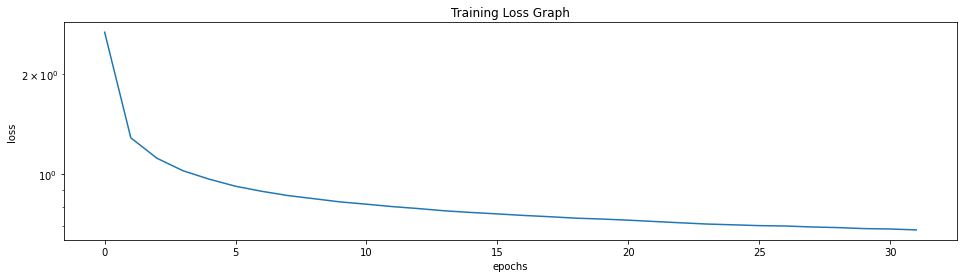

In [24]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [25]:
test_data1 = pd.read_csv("/content/drive/MyDrive/HAI/test1.csv", sep=";", engine="python")
test_data2 = pd.read_csv("/content/drive/MyDrive/HAI/test2.csv", sep=";", engine="python")

In [26]:
TEST_DF_RAW = pd.concat([test_data1, test_data2], axis=0).reset_index(drop=True)

In [27]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z,...,P4_HT_LD,P4_HT_PO,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
0,0.949036,0.676348,0.929214,0.846920,0.875635,0.000000e+00,0.032806,0.784467,9.252600e-02,0.094592,...,8.437011e-01,0.808436,0.0,0.728609,0.460664,0.638897,0.622091,0.0,0.442656,0.999920
1,0.949036,0.674902,0.929214,0.846920,0.875635,0.000000e+00,0.033748,0.782875,9.219418e-02,0.087019,...,8.452013e-01,0.812588,0.0,0.728182,0.466695,0.645250,0.622884,0.0,0.442656,0.999920
2,0.949036,0.678712,0.929214,0.846920,0.875635,0.000000e+00,0.033832,0.787092,9.778861e-02,0.085245,...,8.469801e-01,0.815508,0.0,0.733101,0.468093,0.647396,0.625752,0.0,0.442656,0.999920
3,0.949036,0.680074,0.929214,0.846920,0.875635,0.000000e+00,0.020786,0.788554,9.912289e-02,0.084524,...,8.484859e-01,0.818537,0.0,0.730326,0.454580,0.651250,0.627083,0.0,0.442656,0.999920
4,0.949036,0.681507,0.929214,0.846920,0.875635,0.000000e+00,0.017307,0.790139,9.892319e-02,0.084316,...,8.502783e-01,0.822165,0.0,0.737297,0.498444,0.652711,0.635857,0.0,0.442656,0.999920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444595,0.015152,0.554482,0.101153,0.895011,0.875635,1.017529e-04,0.003965,0.686397,5.868424e-93,0.000227,...,3.472055e-198,0.000219,0.0,0.294465,0.461483,0.400120,0.370521,0.0,0.361972,0.999365
444596,0.015152,0.552691,0.101153,0.895011,0.875635,1.017529e-05,0.005680,0.687438,5.868424e-94,0.000227,...,3.472055e-199,0.000219,0.0,0.294355,0.481219,0.405060,0.373854,0.0,0.360342,0.999647
444597,0.015152,0.554838,0.101153,0.895011,0.875635,1.017529e-06,0.004919,0.685354,5.868424e-95,0.000227,...,3.472055e-200,0.000219,0.0,0.292955,0.482340,0.402823,0.375758,0.0,0.360179,0.999603
444598,0.015152,0.556081,0.101153,0.895011,0.875635,1.017529e-07,0.005775,0.687708,5.868424e-96,0.000227,...,3.472055e-201,0.000219,0.0,0.297647,0.497807,0.404586,0.380051,0.0,0.360163,0.999598


In [28]:
boundary_check(TEST_DF)

(True, True, False)

In [29]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=TEST_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_TEST[0]

  0%|          | 0/444591 [00:00<?, ?it/s]

# of valid windows: 444582


{'attack': 0.0,
 'ts': '2019-10-29 11:00:09',
 'given': tensor([[ 0.9490,  0.6763,  0.9292,  0.8469,  0.8756,  0.0000,  0.0328,  0.7845,
           0.0925,  0.0946,  1.0000,  0.9976,  0.4336,  0.3924,  0.5554,  0.7305,
           0.0091,  0.0338,  0.7973,  0.8181,  0.3690,  0.4418,  0.8066,  0.7793,
           0.7746,  0.0000, -1.3531,  0.4331,  0.0080,  0.7289,  0.4304,  0.4426,
           0.0000,  0.0000,  0.0000,  0.0000,  0.2917,  0.0000,  0.4935,  0.1582,
           0.1334,  0.2080,  0.3037,  0.0862,  0.8029,  0.0000,  0.0000,  0.3667,
           0.5009,  0.8437,  0.8084,  0.0000,  0.7286,  0.4607,  0.6389,  0.6221,
           0.0000,  0.4427,  0.9999],
         [ 0.9490,  0.6749,  0.9292,  0.8469,  0.8756,  0.0000,  0.0337,  0.7829,
           0.0922,  0.0870,  1.0000,  0.9972,  0.4338,  0.3924,  0.5487,  0.7359,
           0.0055,  0.0338,  0.7955,  0.8132,  0.3694,  0.4418,  0.8081,  0.7803,
           0.7764,  0.0000, -1.3531,  0.4328,  0.0101,  0.7289,  0.4304,  0.3105,
     

In [30]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [31]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 12.7 s, sys: 73.7 ms, total: 12.8 s
Wall time: 12.8 s


In [32]:
CHECK_DIST.shape

(444582, 59)

In [33]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [34]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

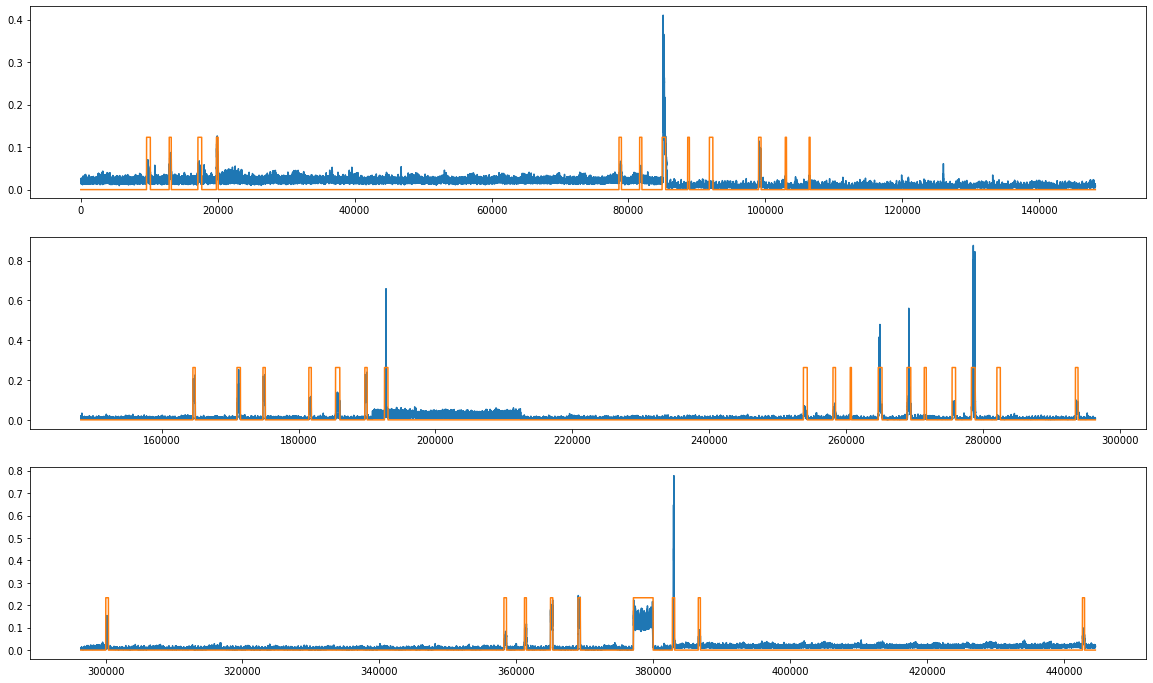

In [35]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3)

In [36]:
from scipy import signal
b, a = signal.butter(1, 0.01, btype='lowpass')

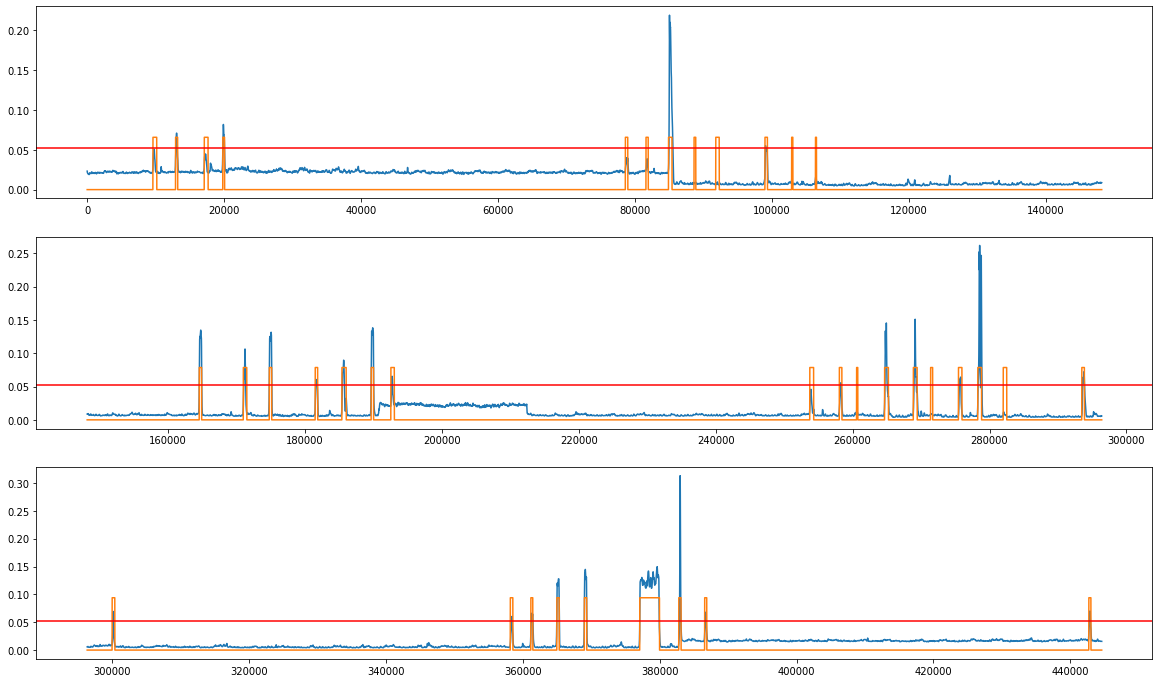

In [37]:
check_graph(signal.filtfilt(b,a,ANOMALY_SCORE), CHECK_ATT, THRESHOLD=0.052,piece=3)

In [38]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs
ATTACK_LABELS = put_labels(np.array(TEST_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (444600,))

In [39]:
ANOMALY_SCORE_smooth = signal.filtfilt(b,a,ANOMALY_SCORE)

In [40]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label
    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []
    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [41]:
THRESHOLD = 0.0308
LABELS = put_labels(ANOMALY_SCORE_smooth, THRESHOLD)
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(TEST_DF_RAW[TIMESTAMP_FIELD]))
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)

print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.758 (TaP: 0.845, TaR: 0.687)
# of detected anomalies: 31
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fbf24282fd0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf24282c70>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf24282940>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf24282b20>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf24282a00>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf58157190>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a7970>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a7d30>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf24282d00>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a76a0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a7730>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a7a00>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a7400>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a7130>, <TaPR_pkg.DataManage.Range.Range object at 0x7fbf242a7c10>, <TaPR_pkg.DataMa

In [ ]:
for i in range(0,15):
    THRESHOLD = 0.03+i*0.0001
    LABELS = put_labels(ANOMALY_SCORE_smooth, THRESHOLD)
    FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(TEST_DF_RAW[TIMESTAMP_FIELD]))
    TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
    print(f"Threshold : {THRESHOLD}")
    print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
    print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
    print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

Threshold : 0.03
F1: 0.755 (TaP: 0.836, TaR: 0.689)
# of detected anomalies: 31
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f38c1eedbe0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c1eedc70>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c1eedf10>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c1eed880>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38bae9e520>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c072f4c0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c072f9d0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c072fc10>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38bd6e8430>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38bd6e8460>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38bd6e8c70>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38bd6e8490>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c2139e50>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c21398b0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f38c2139040>,

In [42]:
submission = pd.read_csv('/content/drive/MyDrive/HAI/sample_submission.csv')
submission.index = submission['timestamp']
submission['attack'] = FINAL_LABELS

In [43]:
submission['attack'].value_counts()

0    430767
1     13833
Name: attack, dtype: int64

In [44]:
submission['attack'].value_counts()

0    430767
1     13833
Name: attack, dtype: int64

In [45]:
submission.to_csv('stackedGRU758.csv', index=False)